In [1]:
###Importing stuff
import numpy as np
np.random.seed(12)
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import time
import seaborn as sns
import copy

In [1]:
import go_out

ModuleNotFoundError: No module named 'go_out'

#### Define events and their resulting transitions
- We will start with basic events of transmission and recovery (SIR without demography).
- Four additional events enter the equation when birth and death is initialized (death rate for every compartment).
- Imports can be subsequently added for extinction prevention, one additional event.
State transitions are obvious and can be found in the book.

##### Beneath, deterministic SIR by ODE's is defined for comparison

In [2]:
def transition(x,y,z,event):
    #Returns the resulting no. of susceptibles, infectious and recovered (x, y and z)

    #Parameters:
    #    x, y, z (int): No. of susceptibles, infectious and recovered
    #    event (str): name of occurring event

    #Returns:
    #    x, y, z (int): No. of susceptibles, infectious and recovered after event
    
    if event == 'birth':
        x += 1
    if event == 'transmission':
        x -= 1
        y += 1
    if event == 'recovery':
        y -= 1
        z += 1
    if event == 'x_death':
        x -= 1
    if event == 'y_death':
        y -= 1
    if event == 'z_death' :
        z -= 1
    if event == 'import' :
        y += 1
        x -= 1
    return x, y, z

def det_ODE(init, t, beta, gamma, mu, rho=0,omega=[0,0]):
    x, y, z = init
    n=x+y+z
    dxdt = mu*n - (1+omega[0]*np.cos(omega[1]*t))*beta*x*y/n - mu*x
    dydt = (1+omega[0]*np.cos(omega[1]*t))*beta*x*y/n - gamma*y - mu*y 
    dzdt = (1 - rho) * gamma*y - mu*z
    return [dxdt, dydt, dzdt]

#### Create simulation by Gillespie's Direct Algorithm
Describes function for creating a simulation based on various conditions (demography yes or no, import yes or no)

In [3]:
def simulation(T=50,x=1500,y=15,z=0,beta=2.,gamma=1.,mu=0.01,demo=True,imports=False,omega=[0,0]):
    #Initializes a discrete event model and simulates T timesteps by GDA.
    #Returns a tuple of [timesteps] and [susceptibles], [infectious] and [recovered] per timestep

    #Parameters:
    #    T (int): No. of timesteps to simulate
    #    x, y, z (int): No. of susceptibles, infectious and recovered
    #    beta, gamma, mu (float): Transmission, recovery and birth&death rate
    #    demo, imports (bool): Whether to include demography and imports

    #Returns:
    #    sim_results (tuple): a tuple of [timesteps] and [susceptibles], [infectious] and [recovered] per timestep
    n = x + y + z
    t = 0
    t_list, x_list, y_list, z_list = [], [], [], []    

    if demo: #Create possible events for different set-ups
        if imports:
            events = ('birth','transmission','recovery','x_death','y_death','z_death','import')
        else:
            events = ('birth','transmission','recovery','x_death','y_death','z_death')
    else:
        if imports:
            events = ('transmission','recovery','import')
        else:
            events = ('transmission','recovery')
            
            
    while t < T:
        beta_t = beta*(1+omega[0]*np.cos(omega[1]*(t))) #beta can be time-varying if omega not [0,0]
        if demo:  #Create rate lists for different set-ups
            R0 = beta_t/(mu+gamma)
            if imports:
                rates = (mu*n,beta_t*x*y/n,gamma*y,mu*x,mu*y,mu*z,0.0625*mu*(R0-1)*np.sqrt(n))
                #rates = (mu*n,beta_t*x*y/n,gamma*y,mu*x,mu*y,mu*z,0.000055*np.sqrt(n))

            else:
                rates = (mu*n,beta_t*x*y/n,gamma*y,mu*x,mu*y,mu*z)
        else:
            R0 = beta_t/gamma
            if imports:
                rates = (beta_t*x*y/n,gamma*y,0.0625*mu*(R0-1)*np.sqrt(n))
            else:
                rates = (beta_t*x*y/n,gamma*y)
        
        #Create variables of combined random generated numbers to determine next event
        rates_total = sum(rates)
        delta_t = -np.log(np.random.uniform())/rates_total
        p = np.random.uniform()*rates_total
        #Determine next event and update variables
        for m, ev in enumerate(events):
            if p <= sum(rates[:m+1]) and p > sum(rates[:m]):
                x, y, z = transition(x,y,z,ev)
                n = x + y + z
                break
        #Append new x, y and z to lists for plotting
        t = t + delta_t
        t_list.append(t)
        x_list.append(x)
        y_list.append(y)
        z_list.append(z)
        
    return (t_list, x_list, y_list, z_list)

# 5 Hallmarks

### 1. Variability between simulations
To present this subject, a couple of simulations are performed for 2 parameter settings. The results of simulations are plotted with their deterministic variant and the variability in results becomes obvious.

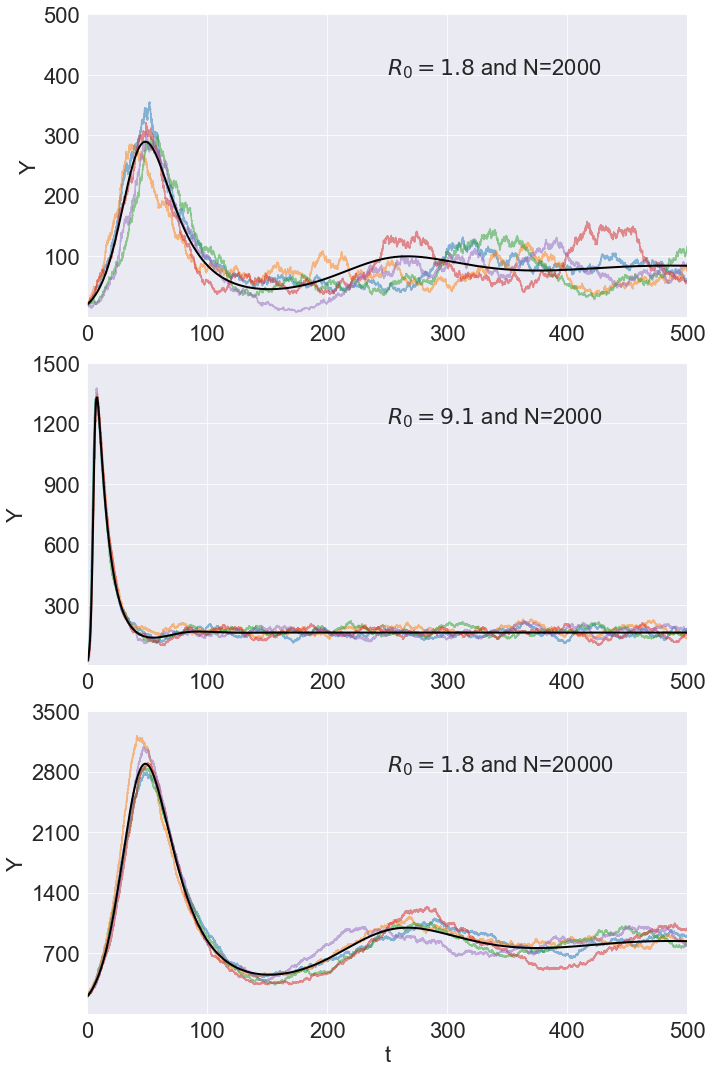

In [345]:
sns.set_style("darkgrid")
n_sim = 5 #Define number of simulations
beta1, beta2, gamma, mu = 0.2, 1, 0.1, 0.01
T = 500
x0 = 1980
y0 = 20
z0 = 0

fig, im = plt.subplots(3, 1, sharex=False,figsize=(10,15))
#Simulate n_sim times and plot
np.random.seed(12)
for i in range(n_sim):
    sim1 = simulation(T,x0,y0,z0,beta1,gamma,mu,imports=True)
    im[0].plot(sim1[0], sim1[2],label='_nolegend_',alpha=0.5)
    sim2 = simulation(T,x0,y0,z0,beta2,gamma,mu,imports=True)
    im[1].plot(sim2[0], sim2[2],label='_nolegend_',alpha=0.5)
    sim3 = simulation(T,x0*10,y0*10,z0,beta1,gamma,mu,imports=True)
    im[2].plot(sim3[0], sim3[2],label='_nolegend_',alpha=0.5)

#Add deterministic plots
det_SIR1 = integrate.odeint(det_ODE, [x0,y0,z0], np.linspace(0,T,T*10), args = (beta1, gamma, mu))
det_SIR2 = integrate.odeint(det_ODE, [x0,y0,z0], np.linspace(0,T,T*10), args = (beta2, gamma, mu))
det_SIR3 = integrate.odeint(det_ODE, [x0*10,y0*10,z0], np.linspace(0,T,T*10), args = (beta1, gamma, mu))
im[0].plot(np.linspace(0,T,T*10),det_SIR1[:,1],'k',linewidth=2,label='Deterministic SIR')
im[1].plot(np.linspace(0,T,T*10),det_SIR2[:,1],'k',linewidth=2,label='Deterministic SIR')
im[2].plot(np.linspace(0,T,T*10),det_SIR3[:,1],'k',linewidth=2,label='Deterministic SIR')

#Plot settings
plt.subplots_adjust(hspace=0.15)
im[2].set_xlabel('t', fontsize=22)
im[0].set_yticks(np.round(np.arange(100,510,100),0))
im[0].set_yticklabels(np.round(np.arange(100,510,100),0),fontsize=22)
im[0].set_ylim((-1,500))
im[0].text(250, 400, r'$R_0=1.8$ and N=2000', fontsize=22)
im[1].text(250, 1200, r'$R_0=9.1$ and N=2000', fontsize=22)
im[2].text(250, 2800, r'$R_0=1.8$ and N=20000', fontsize=22)
im[1].set_yticks(np.round(np.arange(300,1510,300),0))
im[1].set_yticklabels(np.round(np.arange(300,1510,300),0),fontsize=22)
im[1].set_ylim((-1,1500))
im[2].set_yticks(np.round(np.arange(700,3510,700),0))
im[2].set_yticklabels(np.round(np.arange(700,3510,700),0),fontsize=22)
im[2].set_ylim((-2,3500))
im[2].set_ylabel('Y', fontsize=22)
for i in range(3):
    im[i].set_ylabel('Y', fontsize=22)
    im[i].set_xticks(np.round(np.arange(0,510,100),0))
    im[i].set_xticklabels(np.round(np.arange(0,510,100),0),fontsize=22)
    im[i].set_xlim((-.2,500))
    #im[i].legend()
fig.tight_layout()


fig.savefig('1variability.pdf',dpi=100)



### 2. Negative covariances
Show this for high $R_0$, for low $R_0$ a lot of extinctions so the $(\bar{X},\bar{Y})$ comparison to the determinstic $(X,Y)$ is not very reasonable. This will be discussed in more detail later.

In [332]:
initial_list = [(198,2),(1980,20)]
beta_list = [(0.2,0.1),(0.5,0.1),(1,0.1)]
n_sim = 50
T=500
np.random.seed(12)
#Simulate n_sim times and calculate average endemic state and average covariance
for beta, gamma in beta_list:
    for x0, y0 in initial_list:
        cov_list = []
        endemic_Y = []
        endemic_X = []
        for i in range(n_sim):
            sim = simulation(T,x0,y0,z0,beta,gamma,mu,imports=False)
            cov_list.append(np.cov(sim[1:3])[0][1])
            endemic_Y.append(sim[2][-1])
            endemic_X.append(sim[1][-1])


        det_SIR = integrate.odeint(det_ODE, [x0,y0,z0], np.linspace(0,T,T*10), args = (beta, gamma, mu))
        print('\nPopulation size: '+str(x0+y0)+' and Beta: '+str(beta)+' and Gamma: '+str(gamma))
        print('Average cov(X,Y) over '+str(n_sim)+' simulations: '+str(np.mean(cov_list)))
        print('\nAverage susceptible population (endemic state): \n'+str(np.mean(endemic_X))
              +' for stochastic SIR \n'+str(det_SIR[-1][0])+' for deterministic SIR')
        print('Average infected population (endemic state): \n'+str(np.mean(endemic_Y))
              +' for stochastic SIR \n'+str(det_SIR[-1][1])+' for deterministic SIR')


Population size: 200 and Beta: 0.2 and Gamma: 0.1
Average cov(X,Y) over 50 simulations: -174.60295069844497

Average susceptible population (endemic state): 
199.0 for stochastic SIR 
109.69761722130964 for deterministic SIR
Average infected population (endemic state): 
0.0 for stochastic SIR 
8.38773413376903 for deterministic SIR

Population size: 2000 and Beta: 0.2 and Gamma: 0.1
Average cov(X,Y) over 50 simulations: -2525.8411295776687

Average susceptible population (endemic state): 
1093.06 for stochastic SIR 
1096.9761742166731 for deterministic SIR
Average infected population (endemic state): 
87.52 for stochastic SIR 
83.87734106201616 for deterministic SIR

Population size: 200 and Beta: 0.5 and Gamma: 0.1
Average cov(X,Y) over 50 simulations: -401.0189174185149

Average susceptible population (endemic state): 
131.36 for stochastic SIR 
43.99981784919878 for deterministic SIR
Average infected population (endemic state): 
4.52 for stochastic SIR 
14.181467518788681 for deter

### 3. Increased transients

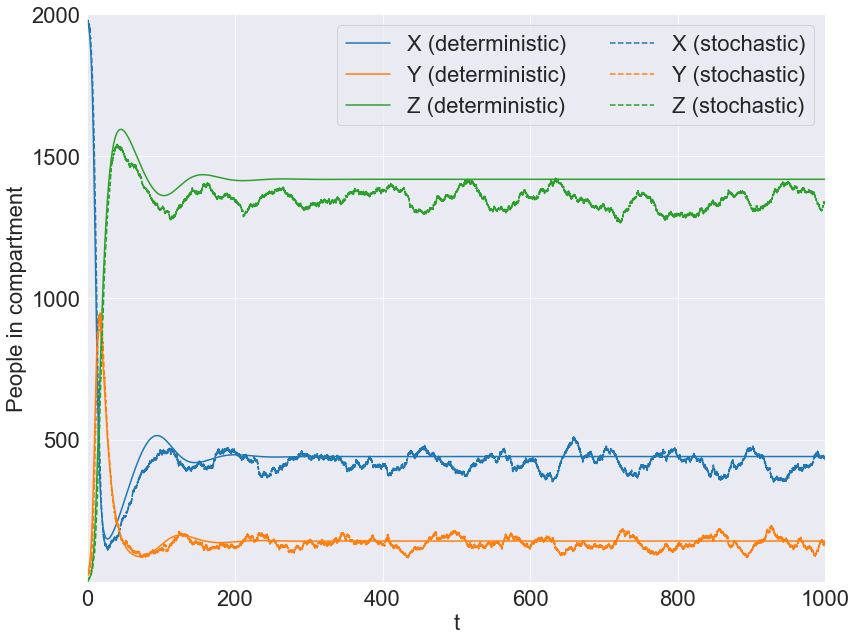

In [344]:
sns.set_style("darkgrid")
beta = 0.5
gamma = 0.1
x0 = 1980
y0 = 20
np.random.seed(12)
T=1000
fig, im = plt.subplots(1, 1, sharex=False,figsize=(12,9))
#Integrate deterministic SIR and plot
det_SIR = integrate.odeint(det_ODE, [x0,y0,z0], np.linspace(0,T,T*10), args = (beta, gamma, mu))
X_det = list(map(lambda x: det_SIR[x][0], range(len(det_SIR))))
Y_det = list(map(lambda x: det_SIR[x][1], range(len(det_SIR))))
Z_det = list(map(lambda x: det_SIR[x][2], range(len(det_SIR))))
im.plot(np.linspace(0,T,T*10),X_det,'C0',label='X (deterministic)')
im.plot(np.linspace(0,T,T*10),Y_det,'C1',label='Y (deterministic)')
im.plot(np.linspace(0,T,T*10),Z_det,'C2',label='Z (deterministic)')


#Simulate stochastic SIR and plot
sim = simulation(T,x0,y0,z0,beta,gamma,mu,imports=True)
im.plot(sim[0], sim[1],'C0',linestyle='--',label='X (stochastic)')
im.plot(sim[0], sim[2],'C1',linestyle='--',label='Y (stochastic)')
im.plot(sim[0], sim[3],'C2',linestyle='--',label='Z (stochastic)')

#Plot settings
im.set_xlabel('t', fontsize=22)
im.set_ylabel('People in compartment', fontsize=22)
im.set_yticks(np.round(np.arange(500,2010,500),0))
im.set_yticklabels(np.round(np.arange(500,2010,500),0),fontsize=22)
im.set_ylim((-2,2000))
im.set_xticks(np.round(np.arange(0,1100,200),0))
im.set_xticklabels(np.round(np.arange(0,1100,200),0),fontsize=22)
im.set_xlim((-.2,1000))
im.legend(fontsize=22,ncol=2)
fig.tight_layout()

fig.savefig('3transients.pdf',dpi=100)

### 4. Stochastic Resonance
Show stochastic resonance and kill it with time-varying beta.

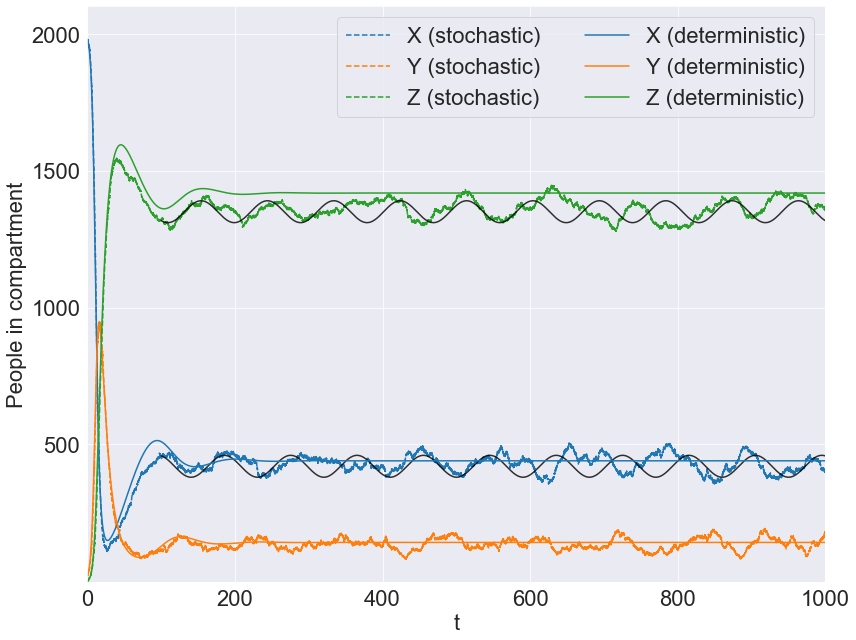

In [343]:
sns.set_style("darkgrid")
beta = 0.5
gamma = 0.1
x0 = 1980
y0 = 20
T = 1000
np.random.seed(12)
fig, im = plt.subplots(1, 1, sharex=False,figsize=(12,9))
#Integrate deterministic SIR and plot
det_SIR = integrate.odeint(det_ODE, [x0,y0,z0], np.linspace(0,T,T*10), args = (beta, gamma, mu, 0, [0,0]))
X_det = list(map(lambda x: det_SIR[x][0], range(len(det_SIR))))
Y_det = list(map(lambda x: det_SIR[x][1], range(len(det_SIR))))
Z_det = list(map(lambda x: det_SIR[x][2], range(len(det_SIR))))
#Simulate stochastic SIR and plot
sim = simulation(T,x0,y0,z0,beta,gamma,mu,omega=[0,0],imports=False)
im.plot(sim[0], sim[1],'C0',linestyle='--',label='X (stochastic)')
im.plot(sim[0], sim[2],'C1',linestyle='--',label='Y (stochastic)')
im.plot(sim[0], sim[3],'C2',linestyle='--',label='Z (stochastic)')
im.plot(np.linspace(100,T,T*10),40*np.sin(np.pi/50*(x+30))+420,'k',alpha=0.8)
im.plot(np.linspace(100,T,T*10),40*np.sin(np.pi/50*(x+65))+1350,'k',alpha=0.8)
# sim = simulation(T,x0,y0,z0,beta,gamma,mu,omega=[0.02,np.pi/50],imports=True)
# im[1].plot(sim[0], sim[1],'C0',linestyle='--',label='X (stochastic)')
# im[1].plot(sim[0], sim[2],'C1',linestyle='--',label='Y (stochastic)')
# im[1].plot(sim[0], sim[3],'C2',linestyle='--',label='Z (stochastic)')

#Plot settings
im.set_xlabel('t', fontsize=22)
# for i in range(2):    
im.plot(np.linspace(0,T,T*10),X_det,'C0',label='X (deterministic)')
im.plot(np.linspace(0,T,T*10),Y_det,'C1',label='Y (deterministic)')
im.plot(np.linspace(0,T,T*10),Z_det,'C2',label='Z (deterministic)')
im.set_ylabel('People in compartment', fontsize=22)
im.set_yticks(np.round(np.arange(500,2010,500),0))
im.set_yticklabels(np.round(np.arange(500,2010,500),0),fontsize=22)
im.set_ylim((-2,2100))
im.set_xticks(np.round(np.arange(0,1100,200),0))
im.set_xticklabels(np.round(np.arange(0,1100,200),0),fontsize=22)
im.set_xlim((-.2,1000))
im.legend(fontsize=22,ncol=2)
fig.tight_layout()
    
fig.savefig('4resonance.pdf',dpi=100)


### 5. Extinctions
Let's first show what happens to the last graph when we turn imports off.
- First same graph as above without imports
- Decreasing beta
- Increasing population
- Use seasonality
- Dan alles fucked and import aan

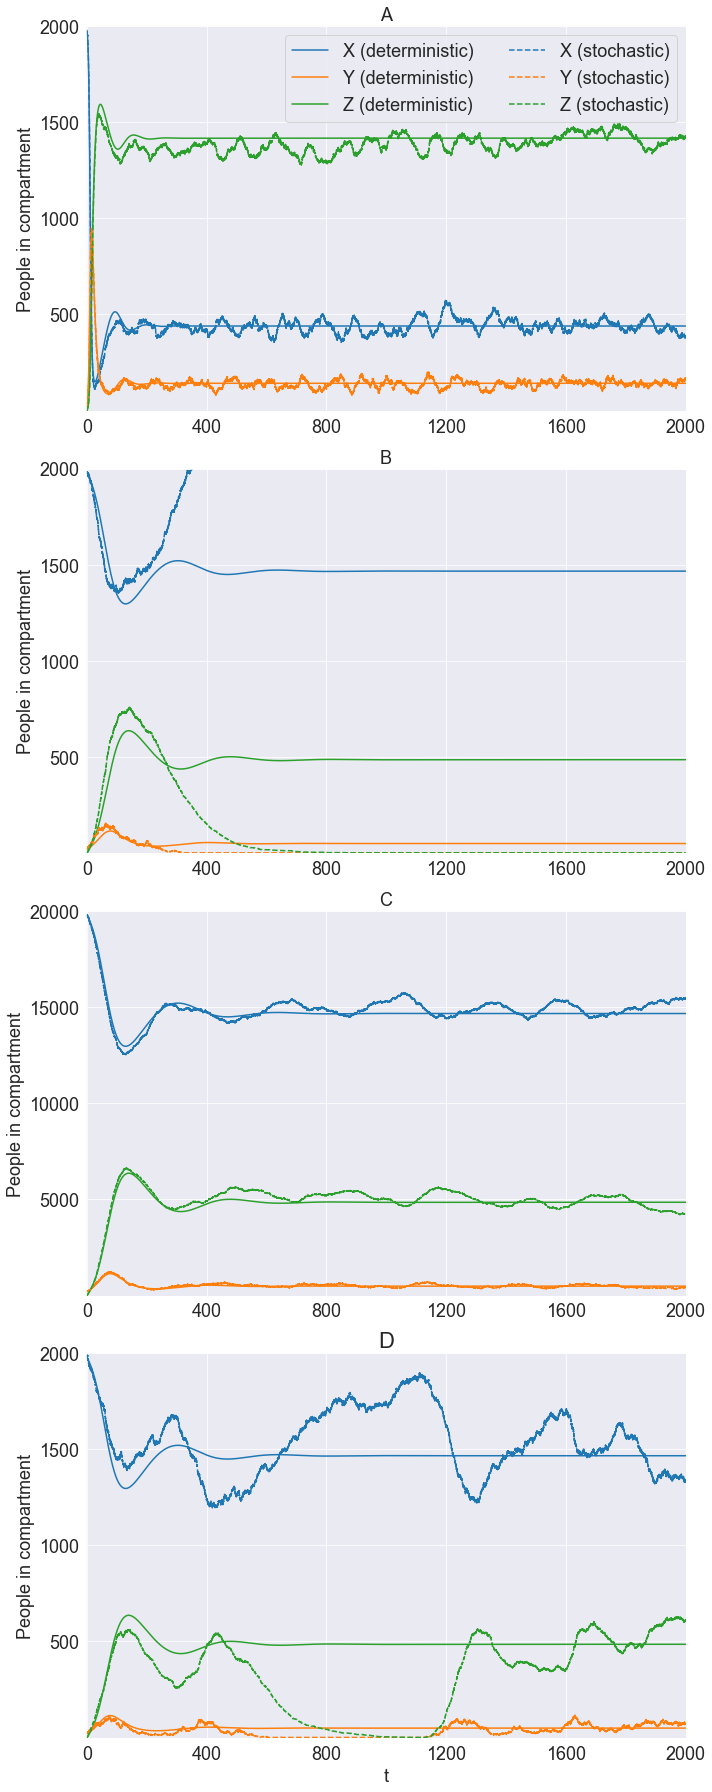

In [342]:
sns.set_style("darkgrid")
beta = 0.5
gamma = 0.1
x0, y0 = 1980, 20
T = 2000
np.random.seed(12)
fig, im = plt.subplots(4, 1, sharex=False,figsize=(10,25))
#Integrate deterministic SIR and plot
det_SIR = integrate.odeint(det_ODE, [x0,y0,z0], np.linspace(0,T,T*10), args = (beta, gamma, mu, 0, [0,0]))
X_det = list(map(lambda x: det_SIR[x][0], range(len(det_SIR))))
Y_det = list(map(lambda x: det_SIR[x][1], range(len(det_SIR))))
Z_det = list(map(lambda x: det_SIR[x][2], range(len(det_SIR))))
im[0].plot(np.linspace(0,T,T*10),X_det,'C0',label='X (deterministic)')
im[0].plot(np.linspace(0,T,T*10),Y_det,'C1',label='Y (deterministic)')
im[0].plot(np.linspace(0,T,T*10),Z_det,'C2',label='Z (deterministic)')
#Simulate stochastic SIR and plot
sim = simulation(T,x0,y0,z0,beta,gamma,mu,omega=[0,0],imports=False)
im[0].plot(sim[0], sim[1],'C0',linestyle='--',label='X (stochastic)')
im[0].plot(sim[0], sim[2],'C1',linestyle='--',label='Y (stochastic)')
im[0].plot(sim[0], sim[3],'C2',linestyle='--',label='Z (stochastic)')
im[0].set_title('A',fontsize=18)


x0, y0, beta = 1980, 20, 0.15
det_SIR = integrate.odeint(det_ODE, [x0,y0,z0], np.linspace(0,T,T*10), args = (beta, gamma, mu, 0, [0,0]))
X_det = list(map(lambda x: det_SIR[x][0], range(len(det_SIR))))
Y_det = list(map(lambda x: det_SIR[x][1], range(len(det_SIR))))
Z_det = list(map(lambda x: det_SIR[x][2], range(len(det_SIR))))
im[1].plot(np.linspace(0,T,T*10),X_det,'C0',label='X (deterministic)')
im[1].plot(np.linspace(0,T,T*10),Y_det,'C1',label='Y (deterministic)')
im[1].plot(np.linspace(0,T,T*10),Z_det,'C2',label='Z (deterministic)')
#Simulate stochastic SIR and plot
sim = simulation(T,x0,y0,z0,beta,gamma,mu,omega=[0,0],imports=False)
im[1].plot(sim[0], sim[1],'C0',linestyle='--',label='X (stochastic)')
im[1].plot(sim[0], sim[2],'C1',linestyle='--',label='Y (stochastic)')
im[1].plot(sim[0], sim[3],'C2',linestyle='--',label='Z (stochastic)')
im[1].set_title('B',fontsize=18)


x0, y0, beta = 19800, 200, 0.15
det_SIR = integrate.odeint(det_ODE, [x0,y0,z0], np.linspace(0,T,T*10), args = (beta, gamma, mu, 0, [0,0]))
X_det = list(map(lambda x: det_SIR[x][0], range(len(det_SIR))))
Y_det = list(map(lambda x: det_SIR[x][1], range(len(det_SIR))))
Z_det = list(map(lambda x: det_SIR[x][2], range(len(det_SIR))))
im[2].plot(np.linspace(0,T,T*10),X_det,'C0',label='_nolegend_')
im[2].plot(np.linspace(0,T,T*10),Y_det,'C1',label='_nolegend_')
im[2].plot(np.linspace(0,T,T*10),Z_det,'C2',label='_nolegend_')
#Simulate stochastic SIR and plot
sim = simulation(T,x0,y0,z0,beta,gamma,mu,omega=[0,0],imports=False)
im[2].plot(sim[0], sim[1],'C0',linestyle='--',label='_nolegend_')
im[2].plot(sim[0], sim[2],'C1',linestyle='--',label='_nolegend_')
im[2].plot(sim[0], sim[3],'C2',linestyle='--',label='_nolegend_')
im[2].set_title('C',fontsize=18)


x0, y0, beta = 1980, 20, 0.15
det_SIR = integrate.odeint(det_ODE, [x0,y0,z0], np.linspace(0,T,T*10), args = (beta, gamma, mu, 0, [0,0]))
X_det = list(map(lambda x: det_SIR[x][0], range(len(det_SIR))))
Y_det = list(map(lambda x: det_SIR[x][1], range(len(det_SIR))))
Z_det = list(map(lambda x: det_SIR[x][2], range(len(det_SIR))))
im[3].plot(np.linspace(0,T,T*10),X_det,'C0',label='X (deterministic)')
im[3].plot(np.linspace(0,T,T*10),Y_det,'C1',label='Y (deterministic)')
im[3].plot(np.linspace(0,T,T*10),Z_det,'C2',label='Z (deterministic)')
#Simulate stochastic SIR and plot
sim = simulation(T,x0,y0,z0,beta,gamma,mu,omega=[0,0],imports=True)
im[3].plot(sim[0], sim[1],'C0',linestyle='--',label='X (stochastic)')
im[3].plot(sim[0], sim[2],'C1',linestyle='--',label='Y (stochastic)')
im[3].plot(sim[0], sim[3],'C2',linestyle='--',label='Z (stochastic)')
im[3].set_title('D',fontsize=22)

#Plot settings
plt.subplots_adjust(hspace=0.15)
im[3].set_xlabel('t', fontsize=18)
for i in range(4):
    im[i].set_ylabel('People in compartment', fontsize=18)
    im[i].set_yticks(np.round(np.arange(500,2010,500),0))
    im[i].set_yticklabels(np.round(np.arange(500,2010,500),0),fontsize=18)
    im[i].set_ylim((-2,2000))
    im[i].set_xticks(np.round(np.arange(0,int(T+10),int(T/5)),0))
    im[i].set_xticklabels(np.round(np.arange(0,int(T+10),int(T/5)),0),fontsize=18)
    im[i].set_xlim((-2,2000))
im[2].set_yticks(np.round(np.arange(5000,20100,5000),0))
im[2].set_yticklabels(np.round(np.arange(5000,20100,5000),0),fontsize=18)
im[2].set_ylim((-2,20000))
im[0].legend(fontsize=18,ncol=2)
fig.tight_layout()

fig.savefig('5extinction.pdf',dpi=100)

#### Number of extinctions per year and percentage of time extinct

<ipython-input-329-cb4bc38e09ec>:34: RuntimeWarning: invalid value encountered in double_scalars
  rates = (mu*n,beta_t*x*y/n,gamma*y,mu*x,mu*y,mu*z,0.0625*mu*(R0-1)*np.sqrt(n))


Run 0 took 18.513592958450317 seconds
Run 1 took 19.689384937286377 seconds
Run 2 took 18.835994005203247 seconds
Run 3 took 19.345541954040527 seconds
Run 4 took 20.05298614501953 seconds
Run 5 took 19.840145111083984 seconds
Run 6 took 19.259175062179565 seconds
Run 7 took 18.540722846984863 seconds
Run 8 took 18.439079999923706 seconds
Run 9 took 18.318164110183716 seconds
Run 10 took 19.126875162124634 seconds
Run 11 took 18.844182014465332 seconds
Run 12 took 18.1994309425354 seconds
Run 13 took 17.89085102081299 seconds
Run 14 took 19.172105312347412 seconds
Run 15 took 18.83725619316101 seconds
Run 16 took 18.498889923095703 seconds
Run 17 took 18.45375895500183 seconds
Run 18 took 19.00195002555847 seconds
Run 19 took 18.099714994430542 seconds
Run 20 took 18.439717054367065 seconds
Run 21 took 18.53365707397461 seconds
Run 22 took 18.6477210521698 seconds
Run 23 took 20.92659306526184 seconds
Run 24 took 18.439741849899292 seconds
Run 25 took 18.537431001663208 seconds
Run 26 

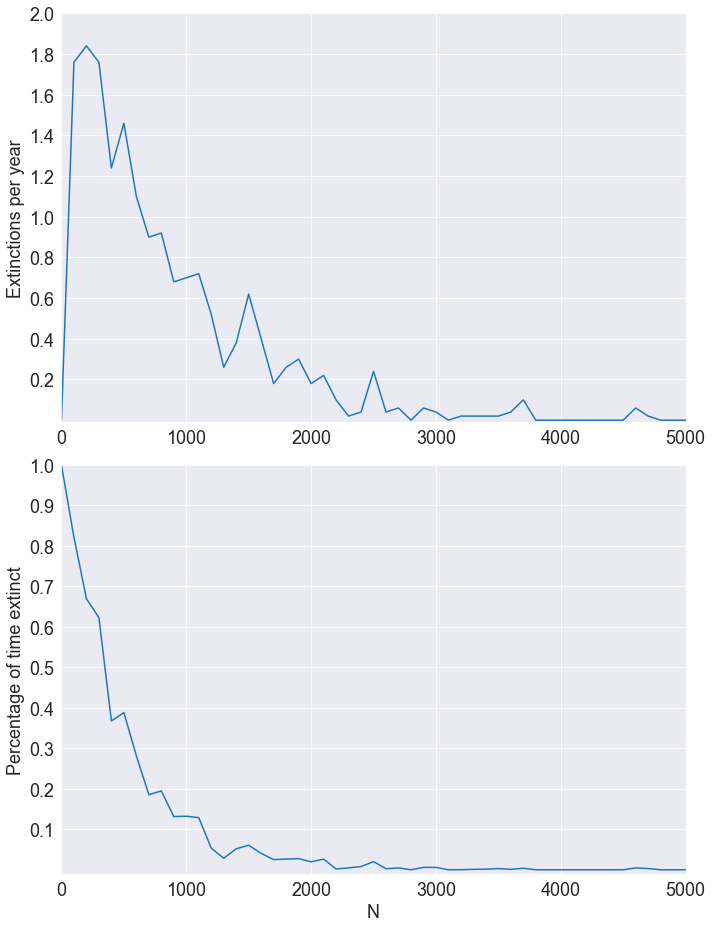

In [346]:
sns.set_style("darkgrid")
beta, gamma = 0.15, 0.1
runs = 50
steps = 51
extinctions = np.zeros((steps))
perc_ext = np.zeros((steps))
N = np.linspace(0,5000,steps)
x0 = 0.99*N
y0 = 0.01*N
T = 365
start = time.time()
for run in range(runs):
    start2 = time.time()
    np.random.seed(run+10)
    for i in range(len(N)):
        sim = simulation(T,x0[i],y0[i],z0,beta,gamma,mu,omega=[0,0],imports=True)
        for j in range(len(sim[2])):
            if sim[2][j] == 0 and sim[2][j-1] != 0:
                extinctions[i] += 1
        percentage = np.count_nonzero(np.array(sim[2])==0)/len(sim[2])
        perc_ext[i] += 1/runs * percentage
    end = time.time()
    print('Run '+str(run)+' took '+str(end-start2)+' seconds')
extinctions /= runs
print('Total took '+str(time.time()-start)+' seconds')

fig, im = plt.subplots(2, 1, sharex=False,figsize=(10,13))
im[0].plot(N,extinctions)
im[1].plot(N,perc_ext)

plt.subplots_adjust(hspace=0.15)
im[1].set_xlabel('N', fontsize=18)
for i in range(2):
    im[i].set_xticks(np.round(np.arange(0,5010,1000),0))
    im[i].set_xticklabels(np.round(np.arange(0,5010,1000),0),fontsize=18)
    im[i].set_xlim((-2,5000))
im[0].set_ylabel('Extinctions per year', fontsize=18)
im[0].set_yticks(np.round(np.arange(0.2,2.1,0.2),2))
im[0].set_yticklabels(np.round(np.arange(0.2,2.1,0.2),2),fontsize=18)
im[0].set_ylim((-0.01,2))
im[1].set_ylabel('Percentage of time extinct', fontsize=18)
im[1].set_yticks(np.round(np.arange(0.1,1.05,0.1),1))
im[1].set_yticklabels(np.round(np.arange(0.1,1.05,0.1),1),fontsize=18)
im[1].set_ylim((-0.01,1))
fig.tight_layout()

fig.savefig('5extinction_2.pdf',dpi=100)


# Metapopulation Model

In [5]:
# Stochastic Meta-Popuation Model
class metapop:
    
    def __init__(self, X0, Y0, Z0, N, n, rho, beta, gamma, T):
        """
        X, Y, Z are vectors with respectively the initial susceptibles, infected and 
        recovered individuals in the n subpopulations. rho is a nxn matrix that gives 
        transmission of population i to population j. Every subpopulation is of the same 
        size N and has the same parameters beta and gamma. T is the timelimit we consider.
        """
        self.X = X0 
        self.Y = Y0
        self.N = N 
        self.Z = Z0 
        self.rho = rho
        self.beta = beta
        self.gamma = gamma
        self.T = T
        self.n = n 
        self.rates = []
        self.X_t = []
        self.Y_t = []
        self.Z_t = []
        self.t = [0]
        self.update()
        
    def update(self):
        """
        Defines how X, Y and Z are updated for the two possible events: infection and 
        recovery. 
        """
        
        # Append new values of X, Y and Z to list
        self.X_t.append(copy.deepcopy(self.X))
        self.Y_t.append(copy.deepcopy(self.Y))
        self.Z_t.append(copy.deepcopy(self.Z))
        
        self.lamda = np.zeros(self.n)
        self.recoveryrate = np.zeros(self.n)
        
        # Determine rates for each subpopulation
        for i in range(self.n): 
            self.recoveryrate[i] = self.Y[i] * self.gamma
            
            for j in range(self.n): 
                self.lamda[i] = self.lamda[i]+self.beta*self.rho[i][j]*self.Y[j]*self.X[i]/self.N
            
        self.rates = np.concatenate((self.lamda, self.recoveryrate), axis=None)      
        
        
    def infected(self, pop_i):
        """
        Transition if susceptible gets infected.
        """
    
        if self.X[pop_i] != 0:
            
            self.X[pop_i] = self.X[pop_i] - 1
            self.Y[pop_i] = self.Y[pop_i] + 1
            
        self.update()
    
    
    def recovered(self, pop_i):
        """
        Transition if infected recovers.
        """
        if self.Y[pop_i] != 0:
        
            self.Y[pop_i] = self.Y[pop_i] - 1
            self.Z[pop_i] = self.Z[pop_i] + 1
            
        self.update()
        
             
    def simulate(self):
        """
        Determines which event in the SIR model happens, performs the event and updates t. 
        """
        delta_t = np.zeros(len(self.rates))
        
        while self.t[-1] < self.T:
            
            # Calculate time until next event happens
            for i in range(len(self.rates)):
                
                # Check for rates of 0 to prevent errors.
                if self.rates[i] == 0:
                        delta_t[i] = self.T
                    
                else:
                    delta_t[i] = (-1 / self.rates[i]) * np.log(np.random.rand())
    
            if np.max(self.rates) == 0.0:
                self.t.append(self.T + 1)
                self.update()
    
            # Find the event p that happens first (infection or recovery)
            else:
                index = np.argmin(delta_t)
                
                if index < self.n:
                    self.infected(index)

                else:
                    self.recovered(index%self.n)

                # Update time
                self.t.append(min(delta_t) + self.t[-1])



#### Simulate metapopulation with n=2 subpopulations for different interaction strengths

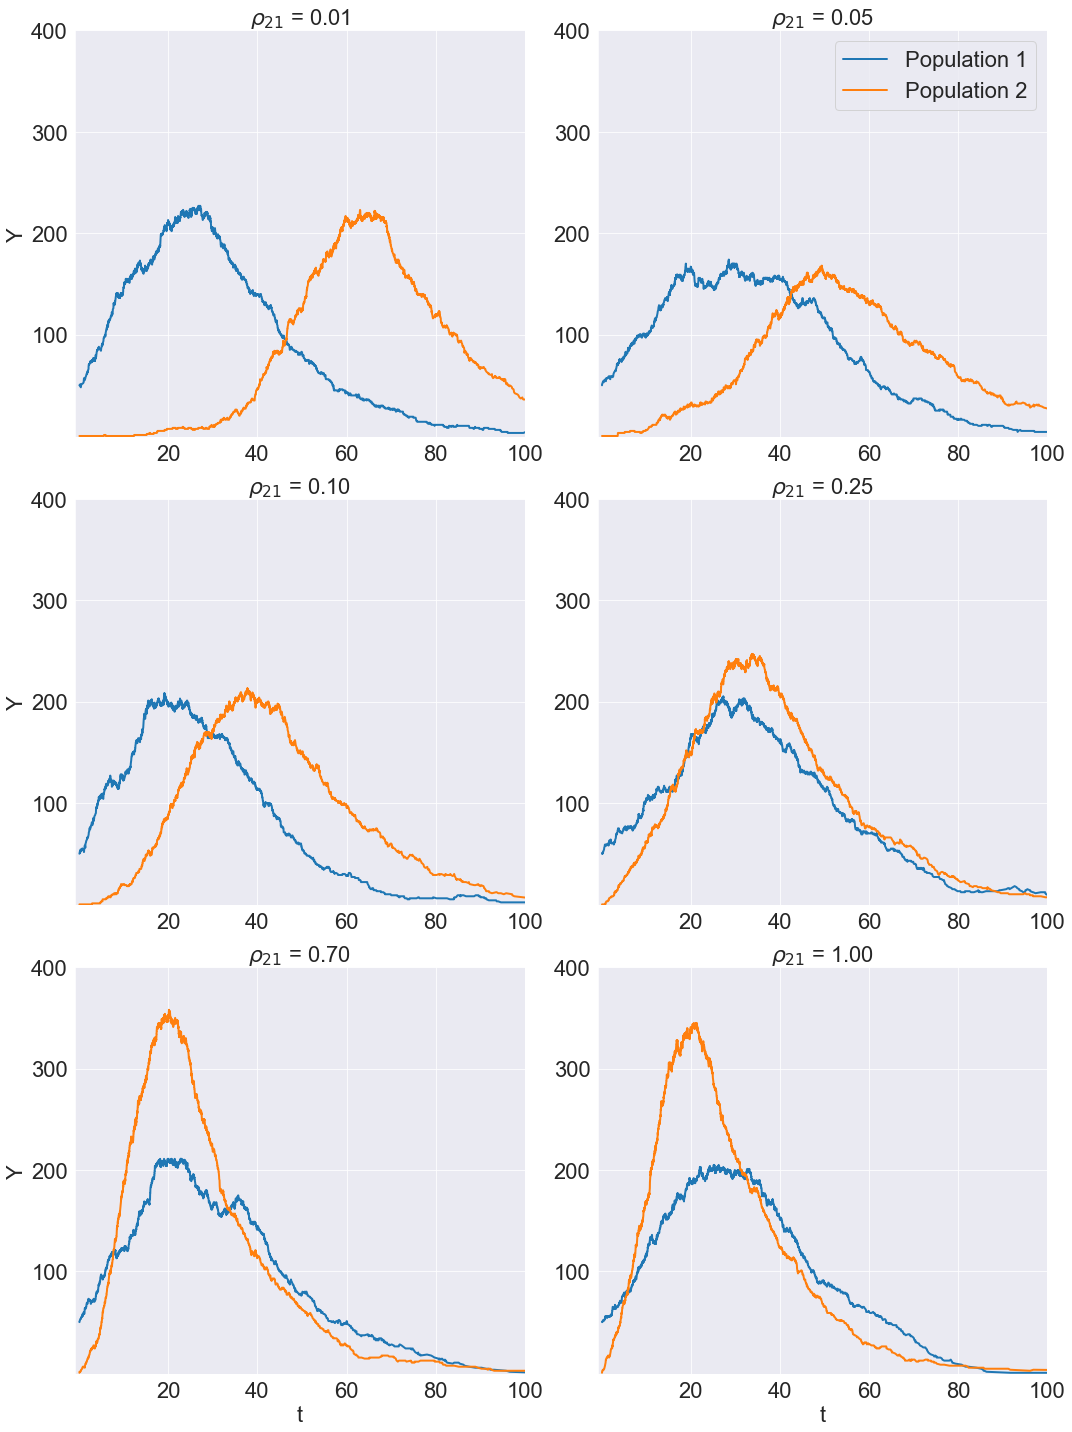

In [48]:
# Declare initial variables
SIR = []
n = 2
beta = 0.2
gamma = 0.1
N = 1000
rho = [[1, 0.0],[0.05, 1]]
T = 100
rho21 = [0.01, 0.05, 0.1, 0.25, 0.7, 1]
r = 0
lag_peak = []
np.random.seed(12)
fig, axs = plt.subplots(3, 2, figsize=(15,20), sharex=False)
plt.subplots_adjust(hspace=0.15)
sns.set_style("darkgrid")

# Plot for different interaction strengths
for i in range(len(rho21)):
    
    X0 = [950, 1000]
    Y0 = [50, 0]
    Z0 = [0, 0]
    
    rho[1][0] = rho21[i]
    
    SIR.append(metapop(X0, Y0, Z0, N, n, rho, beta, gamma, T))
    SIR[i].simulate()
    
    inf_1 = []
    inf_2 = []

    for y in SIR[i].Y_t:
        inf_1.append(y[0])
        inf_2.append(y[1])

    if i%2 == 0 and i != 0:
        r = r + 1
        
    axs[r, i%2].plot(SIR[i].t, inf_1, SIR[i].t, inf_2, linewidth=2)
    axs[r, i%2].set_title('', fontsize=22)
    axs[r, i%2].title.set_text(r'$\rho_{21}$ = %.2f' %(round(rho21[i],2)))
    axs[r, i%2].set_yticks(np.round(np.arange(100,450,100),0))
    axs[r, i%2].set_yticklabels(np.round(np.arange(100,450,100),0), fontsize=22)
    axs[r, i%2].set_xticks(np.round(np.arange(20,110,20),0))
    axs[r, i%2].set_xticklabels(np.round(np.arange(20,110,20),0), fontsize=22)
    axs[r, i%2].set_xlim((-1,100))
    axs[r, i%2].set_ylim((-1,400))

    
    if i%2 == 0:
        axs[r][i%2].set_ylabel('Y', fontsize=22)
    
    if r == 2:
        axs[r][i%2].set_xlabel('t', fontsize=22)
        
    # Calculate lag in peaks
    lag_peak.append(-1*(SIR[i].t[inf_1.index(max(inf_1))] - SIR[i].t[inf_2.index(max(inf_2))]))
    
# Format graph    
axs[0,1].legend(('Population 1', 'Population 2'), fontsize=22)
fig.tight_layout()
fig.savefig('metapop_n_2.pdf',dpi=100)




#### Calculate and plot delays for n=2

In [60]:
# Declare initial variables
n_sim = 50
SIR = []
n = 2
beta = 0.2
gamma = 0.1
N = 1000
rho = [[1, 0.0],[0.05, 1]]
T = 100
rho21 = np.arange(0.01,1.01,0.01)
r = 0
lag_peak = np.zeros((n_sim,len(rho21)))
np.random.seed(12)
# Plot for different interaction strengths
for run in range(n_sim):
    np.random.seed(run+12)
    for i in range(len(rho21)):

        X0 = [950, 1000]
        Y0 = [50, 0]
        Z0 = [0, 0]

        rho[1][0] = rho21[i]

        SIR.append(metapop(X0, Y0, Z0, N, n, rho, beta, gamma, T))
        SIR[i].simulate()

        inf_1 = []
        inf_2 = []

        for y in SIR[i].Y_t:
            inf_1.append(y[0])
            inf_2.append(y[1])

        if i%2 == 0 and i != 0:
            r = r + 1
            
        lag_peak[run,i] = -1*(SIR[i].t[inf_1.index(max(inf_1))] - SIR[i].t[inf_2.index(max(inf_2))])

        
lag_peak = lag_peak.sum(axis=0)/n_sim

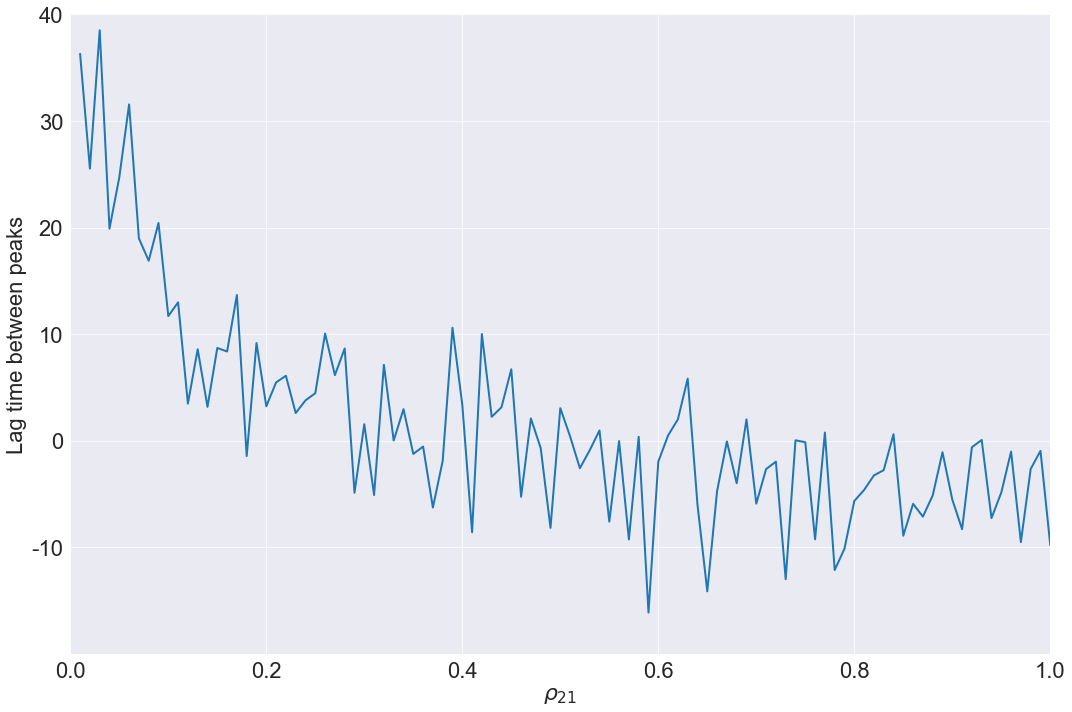

In [63]:
# Plot the delay between the peak of the epidemic in population 1 and the peak in population 2
fig, axs = plt.subplots(1, figsize=(15,10), sharex=False)
axs.plot(rho21,lag_peak, linewidth=2)
axs.set_xlabel(r'$\rho_{21}$', fontsize=22)
axs.set_ylabel('Lag time between peaks', fontsize=22)
axs.set_xticks(np.round(np.arange(0,1.1,0.2),1))
axs.set_xticklabels(np.round(np.arange(0,1.1,0.2),1), fontsize=22)
axs.set_xlim((0,1))
axs.set_yticks(np.arange(-10,45,10))
axs.set_yticklabels(np.arange(-10,45,10), fontsize=22)
axs.set_ylim((-20,40))
fig.tight_layout()
fig.savefig('lag_metapop_n_2.pdf',dpi=100)

#### Simulate metapopulation with 6 subpopulations and different interaction terms

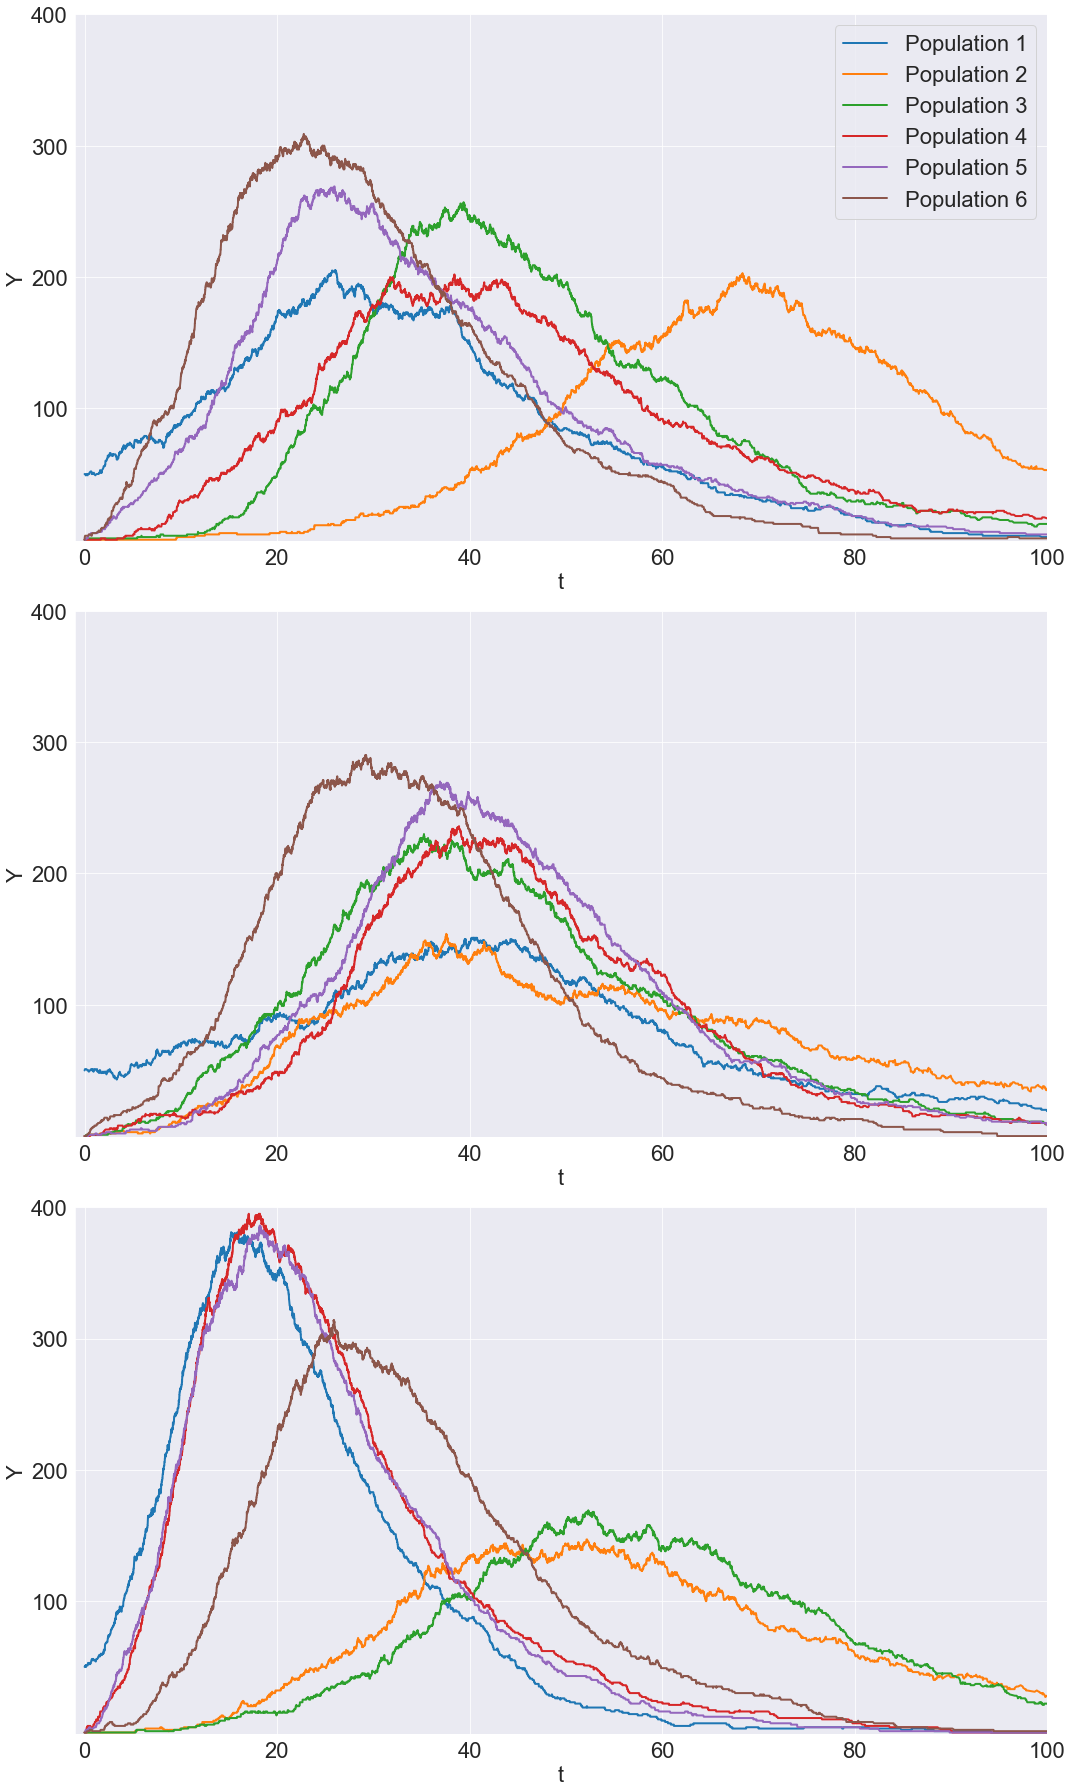

In [72]:
SIR = []
n = 6
N0 = 1000
beta = 0.2
gamma = 0.1
rho = [[[1, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.01, 1, 0.0, 0.0, 0.0, 0.0], 
       [0.05, 0.0, 1, 0.0, 0.0, 0.0],
       [0.1, 0.0, 0.0, 1, 0.0, 0.0],
       [0.25, 0.0, 0.0, 0.0, 1, 0.0], 
       [0.7, 0.0, 0.0, 0.0, 0.0, 1]], 
       [[1, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.1, 1, 0.0, 0.0, 0.0, 0.0], 
       [0.1, 0.1, 1, 0., 0.0, 0.0],
       [0.1, 0.1, 0.1, 1, 0.0, 0.0],
       [0.1, 0.1, 0.1, 0.1, 1, 0.0],
       [0.1, 0.1, 0.1, 0.1, 0.1, 1]],
       [[1, 0.01, 0.7, 0.01, 0.7, 0.2],
       [0.01, 1, 0.0, 0.0, 0.0, 0.0], 
       [0.01, 0.0, 1, 0.0, 0.0, 0.0],
       [0.7, 0.0, 0.0, 1, 0.0, 0.0],
       [0.7, 0.0, 0.0, 0.0, 1, 0.0], 
       [0.2, 0.0, 0.0, 0.0, 0.0, 1]]]

X0 = [950, 1000, 1000, 1000, 1000, 1000]
Y0 = [50, 0, 0, 0, 0, 0]
Z0 = [0, 0, 0, 0, 0, 0]
np.random.seed(12)

fig, axs = plt.subplots(3, figsize=(15, 25), sharex=False)

for i in range(len(rho)):
    
    X0 = [950, 1000, 1000, 1000, 1000, 1000]
    Y0 = [50, 0, 0, 0, 0, 0]
    Z0 = [0, 0, 0, 0, 0, 0]
    
    SIR.append(metapop(X0, Y0, Z0, N, n, rho[i], beta, gamma, T))
    SIR[i].simulate()
    
    inf_1 = []
    inf_2 = []
    inf_3 = []
    inf_4 = []
    inf_5 = []
    inf_6 = []

    for y in SIR[i].Y_t:
        inf_1.append(y[0])
        inf_2.append(y[1])
        inf_3.append(y[2])
        inf_4.append(y[3])
        inf_5.append(y[4])
        inf_6.append(y[5])
    
    
    axs[i].plot(SIR[i].t, inf_1, SIR[i].t, inf_2, SIR[i].t, inf_3, SIR[i].t, inf_4, SIR[i].t, inf_5, SIR[i].t, inf_6, linewidth=2)
    axs[i].set_ylabel('Y', fontsize=22)
    axs[i].set_xlabel('t', fontsize=22)
    axs[i].set_yticks(np.round(np.arange(100,450,100),0))
    axs[i].set_yticklabels(np.round(np.arange(100,450,100),0), fontsize=22)
    axs[i].set_xticks(np.round(np.arange(0,110,20),0))
    axs[i].set_xticklabels(np.round(np.arange(0,110,20),0), fontsize=22)
    axs[i].set_xlim((-1,100))
    axs[i].set_ylim((-1,400))
axs[0].legend(("Population 1","Population 2","Population 3","Population 4","Population 5","Population 6"), fontsize=22)



fig.tight_layout()
fig.savefig('metapop_n_6.pdf',dpi=100)